In [4]:
import tensorflow as tf
import numpy as np
import keras_tuner as kt
import pandas as pd
import seq_generator
import tensorflow.keras.layers as layers
import tensorflow_datasets as tfds
import json
import os
import tqdm


test_ds = seq_generator.get_test_ds(batch_size=20)

def load_ensemble_part(weights,name):
    inputs = tf.keras.Input([260,260,3])

    img_augmentation = tf.keras.models.Sequential(
        [
            tf.keras.layers.RandomRotation(factor=0.15),
            tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
            tf.keras.layers.RandomContrast(factor=0.1),
        ],
        name="img_augmentation",
    )

    x = tf.keras.layers.Resizing(224,224) (inputs)

    x = img_augmentation(x)

    base = tf.keras.applications.EfficientNetB0(
                include_top=False,
                weights='imagenet',
                input_tensor= x)

    base.trainable = False

    x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(base.output)

    cnn =  tf.keras.Model(inputs,x)

    inputs = tf.keras.Input([5,260,260,3],name = 'Image Sequence')
    x = layers.TimeDistributed(cnn,name = "CNN_Feature_Extractor")(inputs)

    x = layers.TimeDistributed( layers.Dropout(0.16892078783969278), name = "Dropout_1") (x)
    
    x = layers.LSTM(192, name = "LSTM")(x)

    x = layers.Dropout(0.2907156272060155,name ="Dropout_2")(x)

    outputs = tf.keras.layers.Dense(2, activation="softmax", name="Predictions",kernel_regularizer=tf.keras.regularizers.L2())(x)


    model = tf.keras.Model(inputs,outputs,name = name)
    model.load_weights(weights)
    model.compile(
        optimizer="Adam",
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model


def build_ensemble():

    inputs = tf.keras.Input([5,260,260,3],name = "Image Sequence")

    eb1 = load_ensemble_part(f"tuner_run/ensemble/weights/b0_ensemple_20_warm/cp.cpkt","Ensemble_Block_1")
    eb2 = load_ensemble_part(f"tuner_run/ensemble/weights/b0_ensemple_4_warm/cp.cpkt","Ensemble_Block_2")
    eb3 = load_ensemble_part(f"tuner_run/ensemble/weights/b0_ensemple_2_warm/cp.cpkt","Ensemble_Block_3")

    x = [model(inputs) for model in [eb1,eb2,eb3]]
    x = tf.math.reduce_mean(x,axis = 0)
    ensemble = tf.keras.Model(inputs,x[:,1],name = "View_Direction_Predictor")

    ensemble.compile(
            optimizer=tf.keras.optimizers.Adam(),
            loss="binary_crossentropy",
            metrics=["accuracy"])
    return ensemble

In [5]:
ensemble = build_ensemble()
# tf.keras.utils.plot_model(ensemble,to_file="../results/model.jpg")

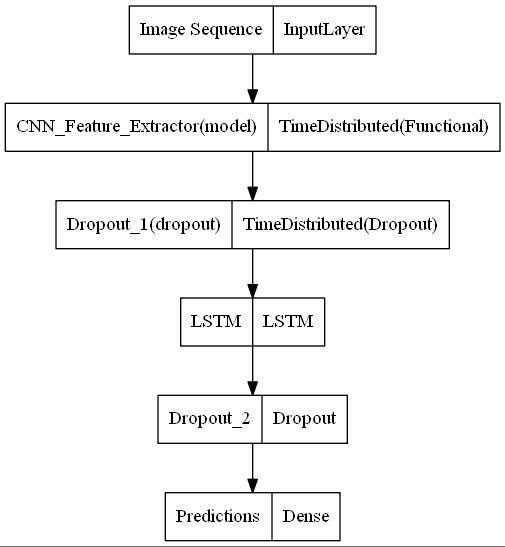

In [2]:
# eb1 = load_ensemble_part(f"tuner_run/ensemble/weights/b0_ensemple_20_warm/cp.cpkt","Ensemble_Block_1")
# tf.keras.utils.plot_model(eb1,to_file="../results/Ensemble_Block.jpg")


In [6]:
preds = ensemble.predict(test_ds,verbose = 1)
labels = list(test_ds.map(lambda x,y : y))

 70/207 [=========>....................] - ETA: 22s

In [3]:
labels = np.concatenate(labels)
acc = (labels == (preds > 0.5)).mean()
acc

0.96297192642788

In [8]:
# test_df = pd.read_feather('test.df').set_index('index')
# test_df['label'] = (test_df.view_direction == 'Sideways').apply(int)
# test_df["lm"] = test_df.label.map({1: 'Lateral',0:'Longitudinal'})
# test_df["prep"] = preds > 0.5
# test_df["pm"] = test_df["prep"].map({1: 'Lateral',0:'Longitudinal'})

# assert (test_df.label == labels).all()

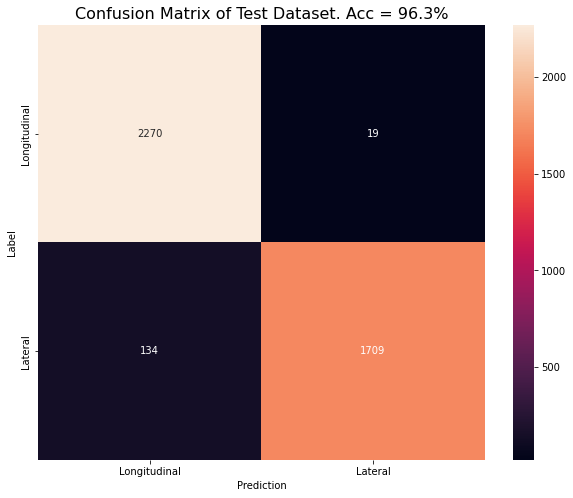

In [13]:
confusion_mtx = tf.math.confusion_matrix(test_df.label,preds > 0.5)
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))

names = ['Longitudinal','Lateral']

sns.heatmap(confusion_mtx, xticklabels=names, yticklabels=names, 
          annot=True, fmt='g')
plt.title(f"Confusion Matrix of Test Dataset. Acc = {acc*100:.1f}%",fontsize=16)
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.savefig('../results/confusion_matrix.jpg')
plt.show()

In [15]:
test_df['pred'] = 0.5 < preds
falsely_pred_front = test_df.loc[(test_df.label != test_df.pred) & (test_df.view_direction == 'Sideways')]
falsely_pred_side = test_df.loc[(test_df.label != test_df.pred) & (test_df.view_direction != 'Sideways')]


def save_false_pred(df,dir,false_pred):
    os.makedirs(dir,exist_ok=True)
    for n in tqdm.tqdm(range(len(df))):

        row = df.iloc[n]
        keys = row['local_path']
        fig, ax = plt.subplots(2,2,figsize=(12,12))
        keys = row['local_path']
        for i,a in enumerate(ax.flatten()):
            try:
                a.imshow(plt.imread(keys[i]))
            except: pass
            a.axis('off')
        plt.suptitle(f"Label: {row['lm']} Pred: {false_pred} City: {row['City'].title()}")
        path = dir +  str(df.index[n]) + ".jpg"
        plt.savefig(path)
        plt.close()
#save_false_pred(falsely_pred_front,"../results/false_predictions/longitudinal/","Lateral")
#save_false_pred(falsely_pred_side,"../results/false_predictions/lateral/","Lateral")


100%|██████████| 19/19 [00:02<00:00,  9.17it/s]


In [14]:
ensemble._name = "View_Direction_Predicter"
ensemble.summary()

Model: "View_Direction_Predicter"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 260, 260  0           []                               
                                , 3)]                                                             
                                                                                                  
 model_1 (Functional)           (None, 2)            5181221     ['input_1[0][0]']                
                                                                                                  
 model_3 (Functional)           (None, 2)            5181221     ['input_1[0][0]']                
                                                                                                  
 model_5 (Functional)           (None, 2)            5181221     ['input_1[

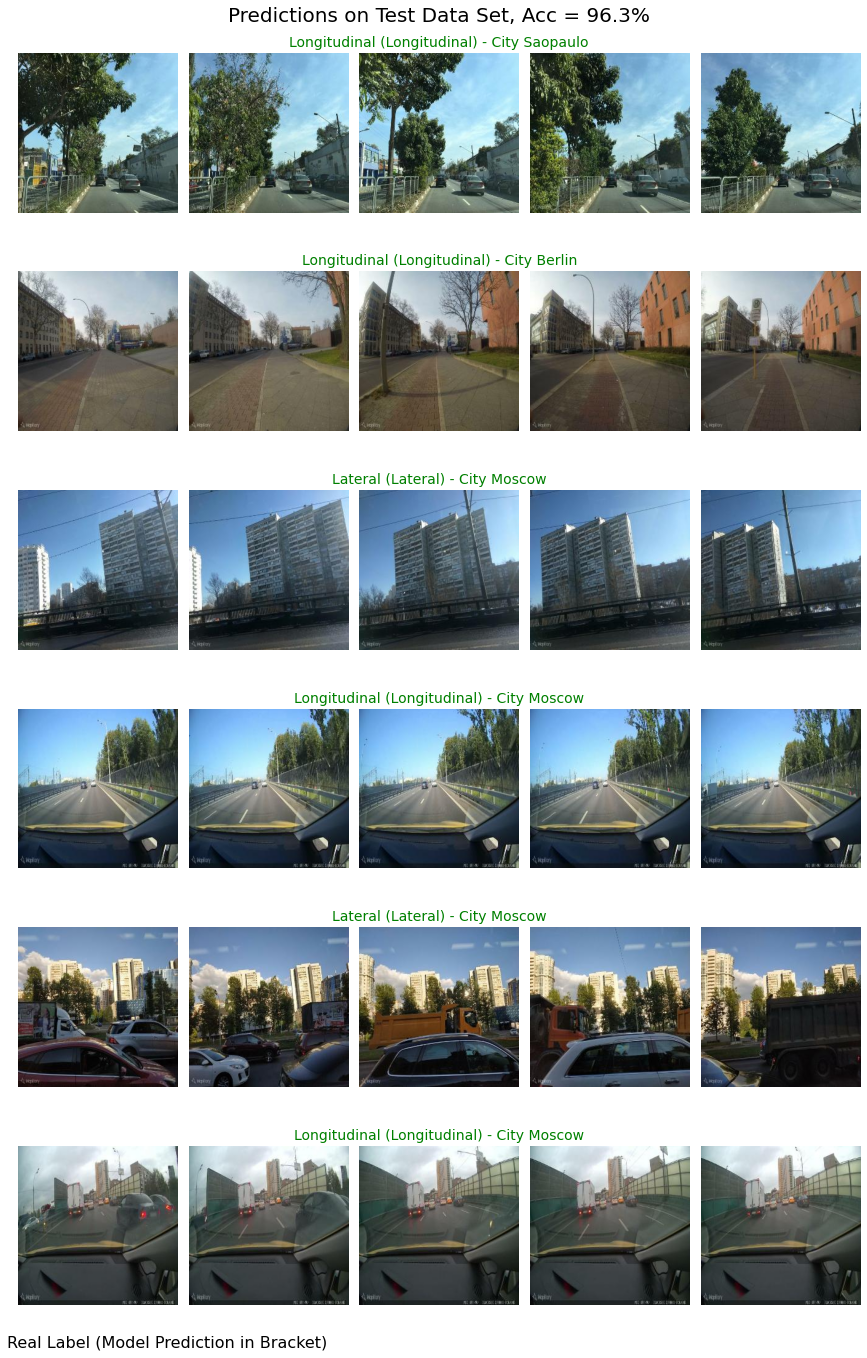

In [17]:
# n = 6

# samples = test_df.sample(n=n)

# fig, ax = plt.subplots(n, 5, figsize=(12, 19))
# dic = {True: 'Lateral',False:'Longitudinal'}
# for row in range(n):
#     seq= samples.iloc[row]
#     keys = seq['local_path']
#     for x,key in enumerate(keys):
#         ax[row,x].imshow(plt.imread(key))
#         ax[row,x].axis('off')
#     p = dic[seq.pred > 0.5 ]
#     l = seq.lm
#     color = 'green' if p==l else 'red'
#     ax[row,2].set_title(f'{l} ({p}) - City {seq["City"].title()}',fontsize = 14,color = color)

# plt.suptitle(f"Predictions on Test Data Set, Acc = {acc*100:.1f}%",fontsize=20)
# plt.figtext(0,0,"Real Label (Model Prediction in Bracket)",fontsize=16)
# plt.tight_layout()
# plt.savefig("../results/Test_Predictions.jpg")
# plt.show()


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
